In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import random

In [2]:

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') 

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # Only supports int and float powers
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
 

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s |  data %.4f | grad % .4f }" %(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.8878749596642844)

In [5]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    
    def __init__(self, nin, nouts):
        self.neurons = [Neuron(nin) for _ in range(nouts)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.4275008318352703),
 Value(data=-0.8837876169429252),
 Value(data=0.9894807927637066)]

In [15]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nouts):
        self.neurons = [Neuron(nin) for _ in range(nouts)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(2, [4, 4, 1])
n(x)

Value(data=0.9054810826390864)

In [17]:
n.parameters()

[Value(data=0.7210789702156934),
 Value(data=0.7544950940405593),
 Value(data=0.5244930042758489),
 Value(data=-0.257146451938973),
 Value(data=0.30405313700874337),
 Value(data=-0.6589896001164486),
 Value(data=0.28383253001770625),
 Value(data=-0.7335833470613999),
 Value(data=-0.4931375858322111),
 Value(data=-0.8342777663547312),
 Value(data=0.8236771826268745),
 Value(data=-0.4233438823324558),
 Value(data=-0.3753990534122402),
 Value(data=-0.3459910460749922),
 Value(data=0.7313109942626943),
 Value(data=0.19986564661962136),
 Value(data=-0.10255706594836034),
 Value(data=0.7734519244136147),
 Value(data=0.4199062440954602),
 Value(data=0.2584692700303899),
 Value(data=0.11373963724130265),
 Value(data=-0.48230136916080113),
 Value(data=-0.7770266005931479),
 Value(data=-0.07317317526044298),
 Value(data=0.9759196141755964),
 Value(data=-0.18197336342338932),
 Value(data=0.25829748066752667),
 Value(data=0.6041685995920163),
 Value(data=0.6069007635513035),
 Value(data=0.49917860

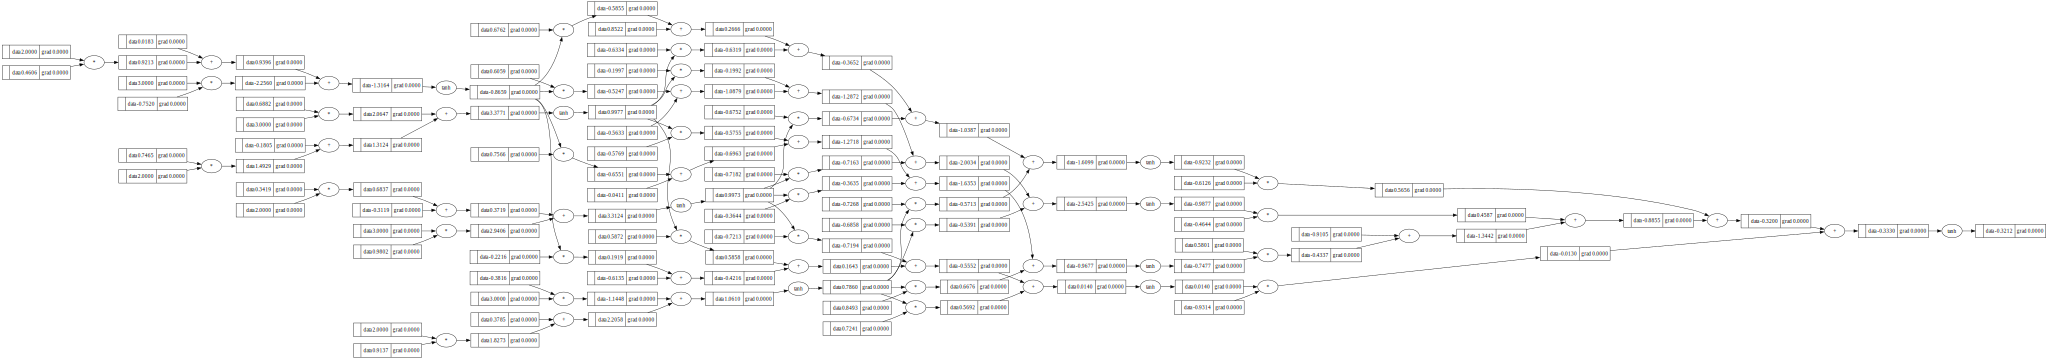

In [8]:
draw_dot(n(x))

In [9]:
# Dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, 0.5],
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.32119887062715047),
 Value(data=-0.7205390409267167),
 Value(data=-0.19735653238637751),
 Value(data=-0.1627640862870466)]

In [10]:
# Loss function
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Value(data=3.8199217398543874)

In [11]:
loss.backward()

In [12]:
n.layers[0].neurons[0].w[0].grad

-1.0537503973150268

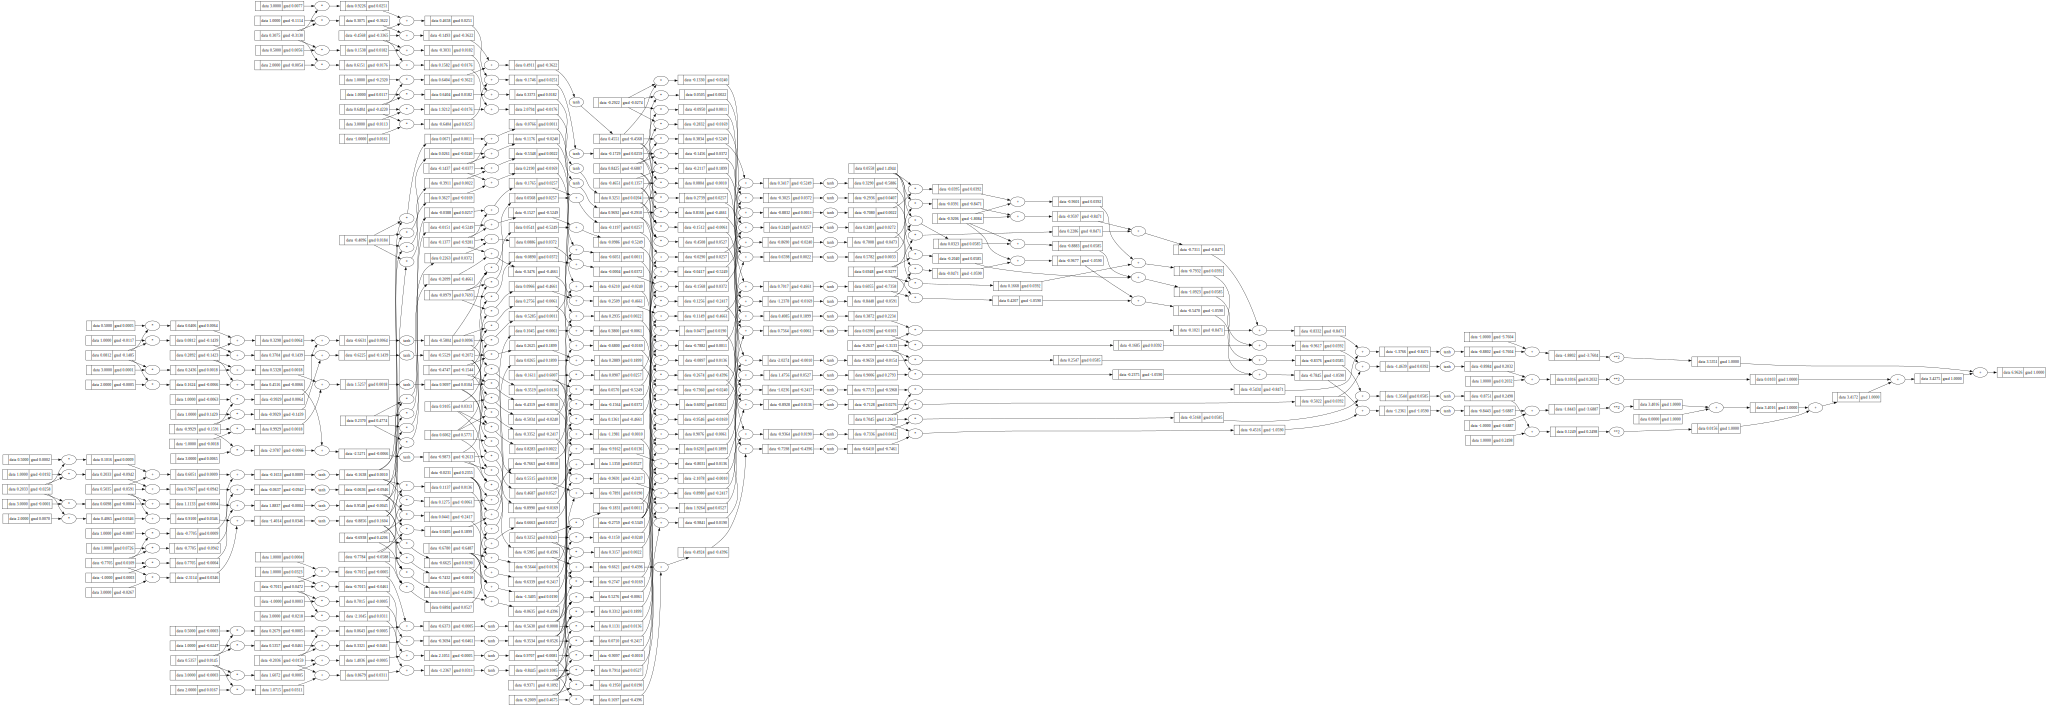

In [53]:
draw_dot(loss)